In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()

Saving prison_dataset.csv to prison_dataset.csv


In [4]:
df=pd.read_csv('prison_dataset.csv')
df.head()

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White,<45,D Felony,Violent,Other,3JD,Parole,Yes,1
1,2010,2013,White,>45,D Felony,Other,Other,3JD,Parole,Yes,1
2,2010,2013,White,<45,D Felony,Other,Other,5JD,Parole,Yes,1
3,2010,2013,White,>45,Other Felony,Drug,Trafficking,3JD,Parole,Yes,1
4,2010,2013,Black,<45,D Felony,Drug,Trafficking,3JD,Parole,Yes,1


In [5]:
def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


In [6]:
def InfoGain(data,split_attribute_name,target_name="cond"):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_name = the name of the feature for which the information gain should be calculated
    3. target_name = the name of the target feature. The default for this example is "class"
    """    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [7]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [8]:
X_random=df.sample(frac=1)
X_tr=X_random[:int(len(df)*0.8)]
X_ts=X_random[int(len(df)*0.8):]

In [9]:
X_tr=X_tr.reset_index(drop=True)

In [10]:
X_ts=X_ts.reset_index(drop=True)

In [31]:
def ID3(data,originaldata,features,target_attribute_name="Recidivism - Return to Prison numeric",parent_node_class = None,J=[],ct=[],current_depth=0,max_depth=6,j=None,depth_mode=True):
    
    #print("j : {}".format(j))#Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    #print("current depth : {}".format(current_depth))
    J.append(j)
    ct.append(current_depth)
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
      #print("current depth : {}".format(current_depth))
      return np.unique(data[target_attribute_name])[0]
    
    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
      #print("current depth : {}".format(current_depth))
      return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    
    elif len(features) ==0 : 
      #print("current depth : {}".format(current_depth))
      return parent_node_class
    
    #If none of the above holds true, grow the tree!
    elif (depth_mode and current_depth==max_depth):
      return data[target_attribute_name].mode()[0]
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        #parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        #print(data)
        parent_node_class = data[target_attribute_name].mode()[0]
        #print("P-node : {}".format(parent_node_class))
        #Select the feature which best splits the dataset
        best_feature  = features[np.argmax([InfoGain(data,feature,target_attribute_name) for feature in features])] #Return the information gain values for the features in the dataset   
        #print("NU= {}".format(nu))     
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        
        tree = {best_feature:{}}
        #print("tree : {}".format(tree))
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #print("len feature : {}".format(len(features)))
        #if

        #Grow a branch under the root node for each possible value of the root node feature
        for j,value in enumerate(np.unique(data[best_feature])):
          #print("This is best-feature : {}".format(best_feature))
          if j==0:
            current_depth+=1
          #print("This is value : {}".format(value))
          #print("j : {}".format(j))
          #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
          sub_data = data[data[best_feature] == value]
            
          #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
          #print(i)  
          
          subtree = ID3(sub_data,data,features,target_attribute_name,parent_node_class,J,ct,current_depth,max_depth,j)
          
          #print("This is subtree : {}".format(subtree))
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
          tree[best_feature][value] = subtree
          #print("this is tree : {}".format(tree))
        return tree
          
                
"""
Train the tree, Print the tree and predict the accuracy
"""
tree = ID3(X_tr,X_tr,X_tr.columns[:-1])
print(tree)


{'Fiscal Year Released': {2010: 1, 2013: {'Convicting Offense Type': {'Drug': {'Release Type': {'Discharged End of Sentence': {'Part of Target Population': {'No': {'Race - Ethnicity': {'Black': {'Convicting Offense Subtype': {'Other': 1, 'Trafficking': 1}}, 'White': {'Age At Release': {'<45': 1, '>45': 1}}}}, 'Yes': {'Convicting Offense Classification': {'D Felony': {'Main Supervising District': {'3JD': 1, '5JD': 1}}, 'Other Felony': {'Age At Release': {'<45': 0, '>45': 0}}}}}}, 'Parole': {'Age At Release': {'<45': {'Part of Target Population': {'No': 1, 'Yes': {'Main Supervising District': {'3JD': 1, '5JD': 1}}}}, '>45': {'Race - Ethnicity': {'Black': {'Main Supervising District': {'3JD': 1, '5JD': 1}}, 'White': {'Part of Target Population': {'No': 1, 'Yes': 1}}}}}}}}, 'Other': {'Age At Release': {'<45': {'Main Supervising District': {'3JD': {'Convicting Offense Classification': {'D Felony': {'Part of Target Population': {'No': 1, 'Yes': 1}}, 'Other Felony': {'Part of Target Populatio

In [ ]:
J.pop(0),ct.pop(0)

(None, 0)

In [ ]:
Cond=[]
for i in range(len(J)-1):
  if J[i:i+2][1]==0:
    Cond.append('Reseting to zero')
  elif J[i:i+2]==[0,1]:
    Cond.append('0 to 1')
  elif J[i:i+2]==[0,2]:
    Cond.append('0 to 2')
  elif J[i:i+2]==[1,2]:
    Cond.append('1 to 2')
  elif J[i:i+2]==[2,1]:
    Cond.append('2 to 1')
  elif J[i:i+2]==[1,1]:
    Cond.append('1 to 1')
  elif J[i:i+2]==[2,2]:
    Cond.append('2 to 2')

Cond.append('End')

In [ ]:
plot_data=pd.DataFrame(np.vstack((np.array(J),np.array(ct),np.array(Cond))).T,columns=['J','Current Depth','Cond'])
plot_data

,J,Current Depth,Cond
0,0,1,0 to 1
1,1,1,Reseting to zero
2,0,2,Reseting to zero
3,0,3,0 to 1
4,1,3,1 to 1
5,1,2,Reseting to zero
6,0,3,0 to 1
7,1,3,1 to 2
8,2,3,2 to 2
9,2,1,Reseting to zero


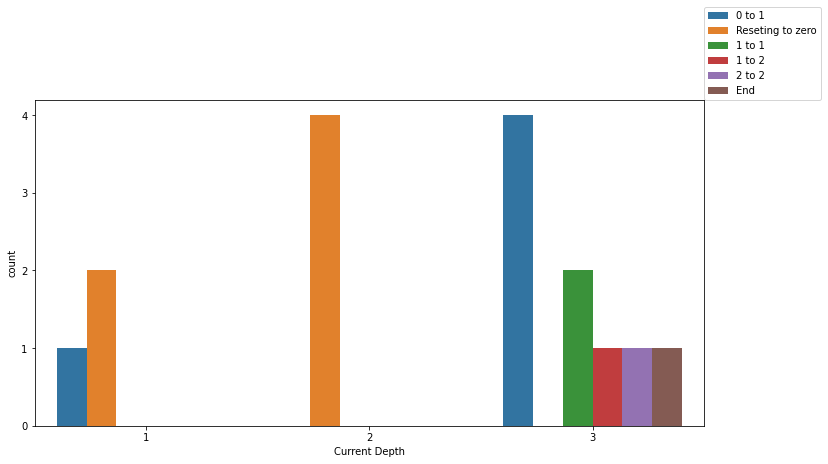

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=plot_data,x='Current Depth',hue='Cond')
plt.legend(loc=(1,1))
plt.yticks(np.arange(0,5,1));

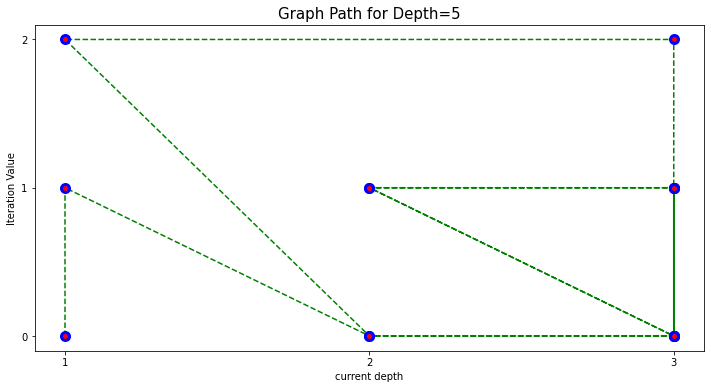

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(ct,J,ls='--',marker='o',color='g',markeredgecolor="b",markerfacecolor="r",ms=8,markeredgewidth=3)
plt.xlabel('current depth')
plt.ylabel('Iteration Value')
plt.title("Graph Path for Depth=5",size=15);
plt.xticks([1,2,3])
plt.yticks([0,1,2]);

In [12]:
def predict(query,tree,default = 1):
    #1.
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result)

            else:
                return result

In [13]:
def test(data,tree):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = pd.DataFrame(columns=["predicted"]) 

    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
    #print(predicted)
    #print(classification_report(data["Recidivism - Return to Prison numeric"].values.astype('int'),predicted['predicted'].values.astype('int')))
    accuracy=(np.sum(predicted["predicted"] == data["Recidivism - Return to Prison numeric"])/len(data))*100
    #print('The prediction accuracy is: ',accuracy,'%')
    #print(sns.heatmap(confusion_matrix(data["Recidivism - Return to Prison numeric"].values.astype('int'),predicted['predicted'].values.astype('int')),annot=True))
    return accuracy

In [14]:
acc=test(X_ts,tree)

Text(0, 0.5, 'Accuracy')

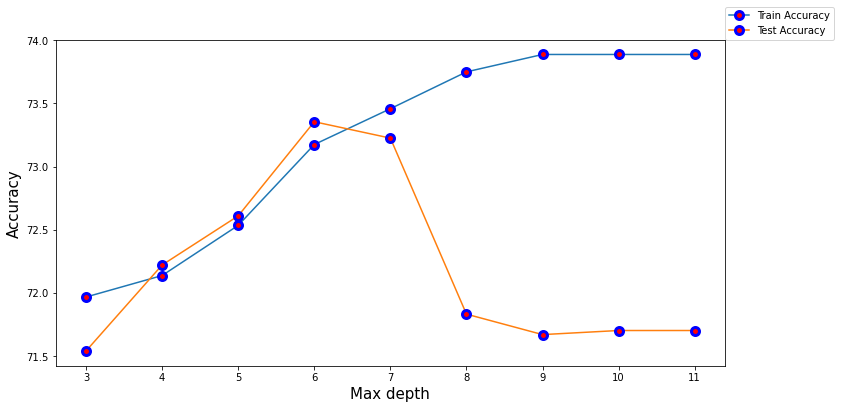

In [ ]:
plt.figure(figsize=(12,6))
acc_train=[]
acc_test=[]
for md in range(3,12,1):
  tree=ID3(X_tr,X_tr,X_tr.columns[:-1],max_depth=md)
  acc_train.append(test(X_tr,tree))
  acc_test.append(test(X_ts,tree))
plt.plot(np.arange(3,12,1),acc_train,marker='o',markeredgecolor="b",markerfacecolor="r",ms=8,markeredgewidth=3,label="Train Accuracy")
plt.plot(np.arange(3,12,1),acc_test,marker='o',markeredgecolor="b",markerfacecolor="r",ms=8,markeredgewidth=3,label="Test Accuracy")
plt.legend(loc=(1,1))
plt.xlabel('Max depth',size=15)
plt.ylabel('Accuracy',size=15)

In [15]:
from sklearn.tree import DecisionTreeClassifier


In [42]:
model = DecisionTreeClassifier(max_depth=5,criterion='entropy')

In [33]:
X=df.drop("Recidivism - Return to Prison numeric",axis=1)
y=df["Recidivism - Return to Prison numeric"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
 from sklearn import preprocessing

In [36]:
le=preprocessing.LabelEncoder()

In [37]:
X_train_encode=np.array([le.fit_transform(col) for col in X_train.values.T]).T
X_test_encode=np.array([le.fit_transform(col) for col in X_test.values.T]).T
X_train_encode

array([[0, 0, 1, ..., 0, 0, 0],
       [2, 2, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [2, 2, 1, ..., 0, 1, 0],
       [2, 2, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [38]:
model.fit(X_train_encode,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [39]:
base_pred = model.predict(X_test_encode)
base_pred

array([1, 1, 0, ..., 0, 0, 1])

In [40]:
confusion_matrix(y_test,base_pred)

array([[ 972,  400],
       [ 504, 1209]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


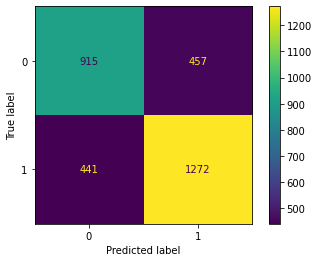

In [25]:
plot_confusion_matrix(model,X_test_encode,y_test)

In [26]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1372
           1       0.74      0.74      0.74      1713

    accuracy                           0.71      3085
   macro avg       0.71      0.70      0.70      3085
weighted avg       0.71      0.71      0.71      3085



In [27]:
from sklearn.tree import plot_tree

In [ ]:
plt.figure(figsize=(33,15),dpi=300)
plot_tree(model,filled=True,feature_names=X.columns,fontsize=30);

Output hidden; open in https://colab.research.google.com to view.

In [28]:
model.feature_importances_

array([0.        , 0.85557717, 0.0030648 , 0.02149907, 0.00347425,
       0.01525394, 0.00304109, 0.03628317, 0.05610867, 0.00569785])

In [41]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)

,Feature Importance
Fiscal Year Released,0.802749
Release Type,0.059628
Main Supervising District,0.040023
Age At Release,0.022386
Convicting Offense Type,0.021963
Part of Target Population,0.014963
Race - Ethnicity,0.014900
Convicting Offense Classification,0.014871
Convicting Offense Subtype,0.008517
Recidivism Reporting Year,0.000000
